# Inputs and explanation

We will read in image coordinates and measured coordinates

We will then regress 5 functions in total, and save them to a new subfolder called 'python_calibration_models'

(1) imCoords_to_XYZ.joblib  

(2) xy_yz_to_xz.joblib  

(3) xz_xy_to_yz.joblib 

(4) xz_yz_to_xy.joblib

# imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
from scipy.interpolate import interp1d
import scipy as sp
import pickle
import glob
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from scipy.signal import savgol_filter, savgol_coeffs
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D  
import time
%load_ext autoreload
import os
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from ipywidgets import Video, Image, VBox, Text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 20200120_calibration

## Load the data

In [3]:
calibration_folder_path = './20200120_calibration/'      


# set the folder containing the calibration information
measured_coord_folder = os.path.join(calibration_folder_path, 'measured_coords/')
image_coord_folder = os.path.join(calibration_folder_path, 'image_coords/')

# make a list of the text files we need to read from each position folder
imcoord_textfileNames = ['Ex_data_corner.txt', 'Ex_data.txt', 'Ez_data_corner.txt', 'Ez_data.txt', \
                         'Fx_data_corner.txt', 'Fx_data.txt', 'Fy_data_corner.txt', 'Fy_data.txt', \
                         'Gy_data_corner.txt', 'Gy_data.txt', 'Gz_data_corner.txt', 'Gz_data.txt']

measured_textfileNames = ['pos1_measured.txt', 'pos1corner_measured.txt',
                          'pos2_measured.txt', 'pos2corner_measured.txt',
                          'pos3_measured.txt', 'pos3corner_measured.txt',
                          'pos4_measured.txt', 'pos4corner_measured.txt']

position_names = ['position1', 'position2', 'position3', 'position4']

# load the measured coordinates
measured_coordinates = []
for i in range(0, len(measured_textfileNames), 2):
    # get paths
    non_corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i])
    corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i+1])
    # load the data
    non_corner_data = np.loadtxt(non_corner_path)
    corner_data = np.loadtxt(corner_path)
    # combine the two
    position_measured_coords = np.concatenate((non_corner_data, corner_data))
    # record
    measured_coordinates.append(position_measured_coords)
full_measured_coordinates = np.vstack(measured_coordinates)

# load the image coordinates
xz_imCoords = []
xy_imCoords = []
yz_imCoords = []

for positionIdx in range(4):
    folder_name = os.path.join(image_coord_folder, position_names[positionIdx])
    
    Ex_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[0]))
    Ex_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[1]))
    Ez_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[2]))
    Ez_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[3]))
    Ex_data = np.concatenate((Ex_non_corner_data, Ex_corner_data))
    Ez_data = np.concatenate((Ez_non_corner_data, Ez_corner_data))
    
    Fx_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[4]))
    Fx_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[5]))
    Fy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[6]))
    Fy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[7]))
    Fx_data = np.concatenate((Fx_non_corner_data, Fx_corner_data))
    Fy_data = np.concatenate((Fy_non_corner_data, Fy_corner_data))
    
    Gy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[8]))
    Gy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[9]))
    Gz_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[10]))
    Gz_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[11]))
    Gy_data = np.concatenate((Gy_non_corner_data, Gy_corner_data))
    Gz_data = np.concatenate((Gz_non_corner_data, Gz_corner_data))
    
    # Combine the two arrays for each cam
    # BIG DANGER OF A SWAP! e.g (Ex,Ez), or (Ez,Ex)
    # WE WANT OPENCV FORMAT I THINK?
    xz_data = np.stack([Ex_data, Ez_data], axis=1)
    xy_data = np.stack([Fx_data, Fy_data], axis=1)
    yz_data = np.stack([Gy_data, Gz_data], axis=1)
    
    # record for this position
    xz_imCoords.append(xz_data)
    xy_imCoords.append(xy_data)
    yz_imCoords.append(yz_data)
    
# combine the data for each position
xz_imCoords = np.concatenate(xz_imCoords)
xy_imCoords = np.concatenate(xy_imCoords)
yz_imCoords = np.concatenate(yz_imCoords)

# combine into master array
full_image_coordinates = np.stack([xz_imCoords, xy_imCoords, yz_imCoords], axis=0)

# load the raw images (if you like - not necessary for regressing functions)
raw_image_folder = os.path.join(calibration_folder_path, 'raw_images')

image_extensions = ['xz_rotation1.tif', 'xz_rotation2.tif', 'xz_rotation3.tif', 'xz_rotation4.tif',
                    'xy_rotation1.tif', 'xy_rotation2.tif', 'xy_rotation3.tif', 'xy_rotation4.tif',
                    'yz_rotation1.tif', 'yz_rotation2.tif', 'yz_rotation3.tif', 'yz_rotation4.tif',
                    ]

image_filepaths = [os.path.join(raw_image_folder, image_extension) for image_extension in image_extensions]

# load the images as a list
images = []
for imPath in image_filepaths:
    images.append(plt.imread(imPath))
    
# turn into an array of shape (numCams, numRotations, 1024, 1280)
calibration_images = np.stack(images)
calibration_images = calibration_images.reshape(3,4,1024,1280)
print()
print('calibration_images_shape: ', calibration_images.shape)
print()
print()

print('-- Full Measured Coordinates --')
print('(numBalls, 3D_coord)')
print(full_measured_coordinates.shape)
print()
print('-- Full Image coordinates --')
print('(numCams, numBalls, 2D_coord)')
print(full_image_coordinates.shape)

total_numBalls = full_measured_coordinates.shape[0]
print(total_numBalls)


calibration_images_shape:  (3, 4, 1024, 1280)


-- Full Measured Coordinates --
(numBalls, 3D_coord)
(200, 3)

-- Full Image coordinates --
(numCams, numBalls, 2D_coord)
(3, 200, 2)
200


## Parse to within interior cage and inspect

Text(0.5, 0, 'Z [cm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
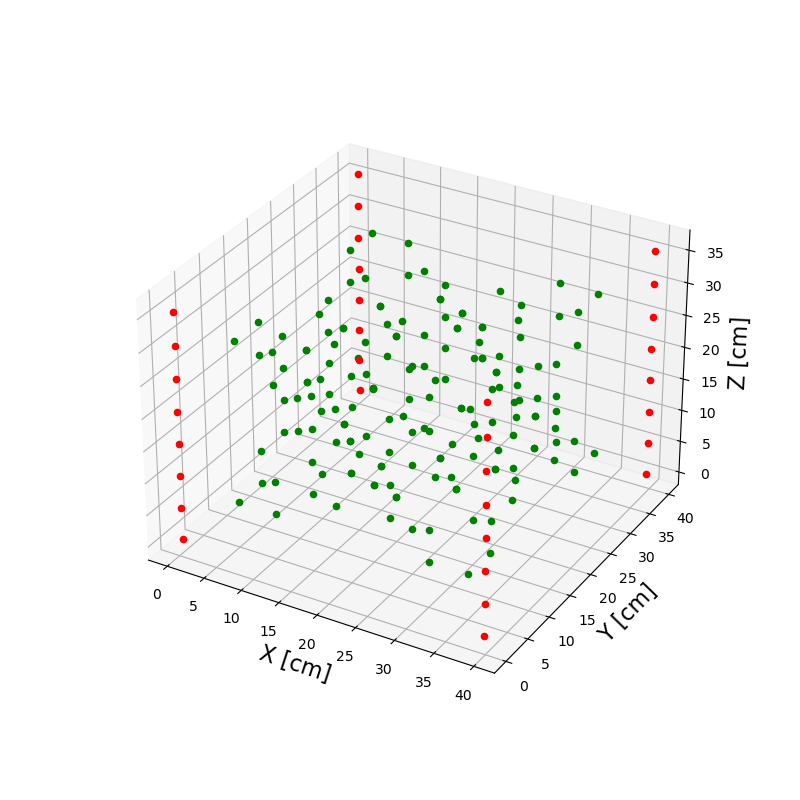

In [4]:
# parse the image coordinates - we only want to use calibration balls which lie within the interior volume

def is_within_interior_cage(XYZ):
    ''' Return True if this 3D values is within the iterior cage,
        False otherwise
    '''
    # define the X, Y and Z ranges of the iterior cage
    iterior_cage_lims = np.array([[5,35],[5,35],[0,32]])
    #iterior_cage_lims = np.array([[0,40],[0,40],[0,40]])

    # preallocate a list to hold the success for the checking of each dimension
    dim_successes = [False]*3
    # check each dimension, does component lie within the cage component limits?
    for i,dim_range in enumerate(iterior_cage_lims):
        if dim_range[0] <= XYZ[i] <= dim_range[1]:
            dim_successes[i] = True
    # If all 3 are successes, then we return True
    if np.all(dim_successes):
        return True
    else:
        return False
    
    
new_meas_list = []
new_im_list = []
within_mask = np.zeros((total_numBalls,), dtype=bool)

for ballIdx in range(total_numBalls):
    if is_within_interior_cage(full_measured_coordinates[ballIdx]):
        new_meas_list.append(full_measured_coordinates[ballIdx])
        new_im_list.append(full_image_coordinates[:,ballIdx])
        within_mask[ballIdx] = True
        
        
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c='g', depthshade=False)
#c=[1,1,0.1,1]

ax.scatter(full_measured_coordinates[~within_mask,0], 
           full_measured_coordinates[~within_mask,1], 
           full_measured_coordinates[~within_mask,2], 
           marker='o', c='r', depthshade=False)

ax.set_xlabel('X [cm]', fontsize=16)
ax.set_ylabel('Y [cm]', fontsize=16)
ax.set_zlabel('Z [cm]', fontsize=16)


#plt.tight_layout() #Tatsuo added 20221030
#plt.savefig('calibration_structure.pdf')
#plt.savefig('calibration_structure.png', dpi=300)

In [6]:
# Now define measured and image coordinates to only use interior points
measured_coordinates = full_measured_coordinates[within_mask]
image_coordinates = full_image_coordinates[:, within_mask]

print(measured_coordinates.shape)
print(image_coordinates.shape)

numBalls = measured_coordinates.shape[0]
print(numBalls)

(168, 3)
(3, 168, 2)
168


/tmp/ipykernel_2176512/2271114367.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
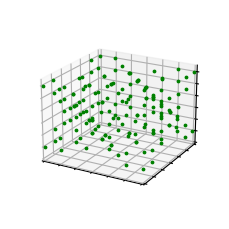

In [7]:
fig = plt.figure(figsize=(2.3,2.3))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c='g', depthshade=False, s=3)

ax.set_xlabel('X [cm]', fontsize=16)
ax.set_ylabel('Y [cm]', fontsize=16)
ax.set_zlabel('Z [cm]', fontsize=16)

ax.set_xlim(5,35)
ax.set_ylim(5,35)
ax.set_zlim(0,32)

# -----------------------------------------------------#

ax.view_init(elev=21, azim=-61)

ax.set_xticks([5,10,15,20,25,30,35])
ax.set_yticks([5,10,15,20,25,30,35])
ax.set_zticks([0,5,10,15,20,25,30])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize=16)
ax.set_zlabel('', fontsize=16)

fig.tight_layout() 
#fig.savefig('/home/liam/temp/image_transfer/SI_calibration_panelA_topright.png', dpi=300, transparent=True)

## prepare the data to use for building the models

In [8]:
# prepare the image coordinates 
xz_xy_image_coordinates = np.copy(image_coordinates[:2,:,:].swapaxes(0,1).reshape(numBalls, -1))
xy_yz_image_coordinates = np.copy(image_coordinates[1:,:,:].swapaxes(0,1).reshape(numBalls, -1))
xz_yz_image_coordinates = np.copy(image_coordinates[::2,:,:].swapaxes(0,1).reshape(numBalls, -1))

xz_image_coordinates = np.copy(image_coordinates[0,:,:])
xy_image_coordinates = np.copy(image_coordinates[1,:,:])
yz_image_coordinates = np.copy(image_coordinates[2,:,:])

# I need to transform from (numCams,numBalls,2) to (numBalls,6)
flat_image_coordinates = np.copy(image_coordinates.swapaxes(0,1).reshape(-1,6))

print(xz_xy_image_coordinates.shape)
print(xy_yz_image_coordinates.shape)
print(xz_yz_image_coordinates.shape)
print()
print(xz_image_coordinates.shape)
print(xy_image_coordinates.shape)
print(yz_image_coordinates.shape)
print()
print(measured_coordinates.shape)
print()
print(flat_image_coordinates.shape)

(168, 4)
(168, 4)
(168, 4)

(168, 2)
(168, 2)
(168, 2)

(168, 3)

(168, 6)


## XZ&XY to YZ

In [9]:
X_data = np.copy(xz_xy_image_coordinates)
Y_data = np.copy(yz_image_coordinates)

In [10]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.01, 'preprocessor__degree': 3}
-0.3666301740588658


t = 0.21793031692504883 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
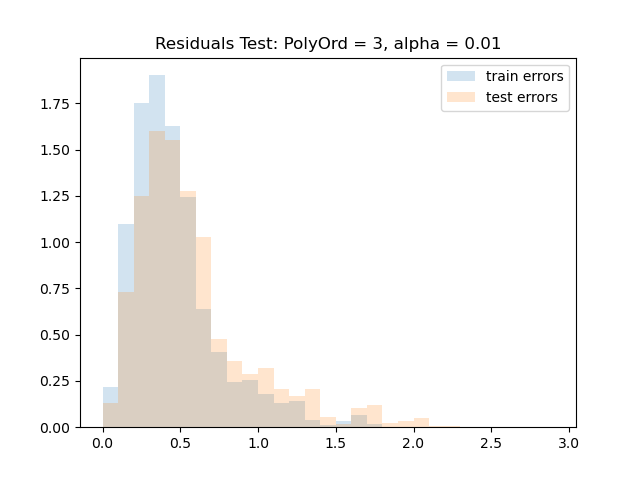

In [11]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [12]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xz_xy_to_yz.joblib'


In [13]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [14]:
# ---- How to load ----#

# # load the model
# yz_getter_name = 'xz_xy_to_yz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));

In [15]:
# ---- compute the final residuals plot ---- #

# load the model
yz_getter_name = 'xz_xy_to_yz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));


calculated_im_coordinates = yz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
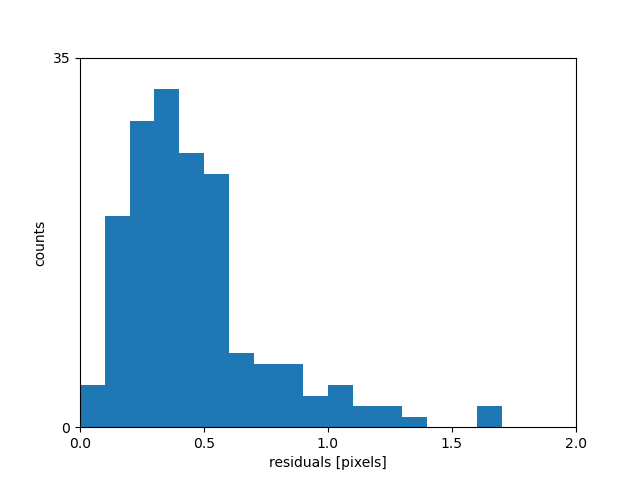

In [16]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])

## XY&YZ to XZ

In [17]:
X_data = np.copy(xy_yz_image_coordinates)
Y_data = np.copy(xz_image_coordinates)

In [18]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.01, 'preprocessor__degree': 3}
-0.32860322111429663


t = 0.21169686317443848 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
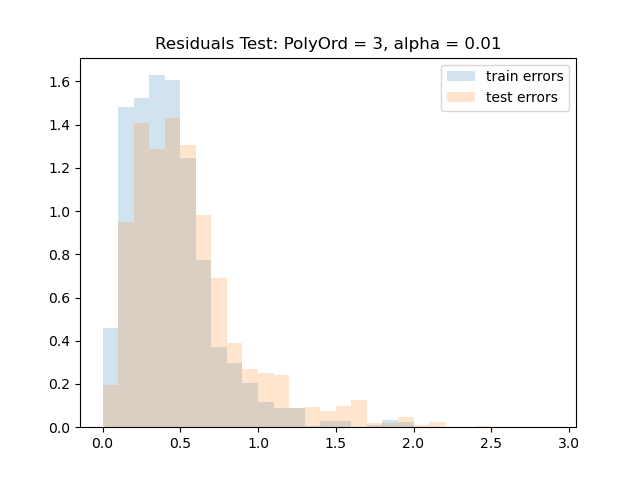

In [19]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [20]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xy_yz_to_xz.joblib'


In [21]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [22]:
# ---- How to load ----#

# # load the model
# xz_getter_name = 'xy_yz_to_xz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));

In [23]:
# ---- compute the final residuals plot ---- #

# load the model
xz_getter_name = 'xy_yz_to_xz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));


calculated_im_coordinates = xz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Text(0.5, 0, 'pixels')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
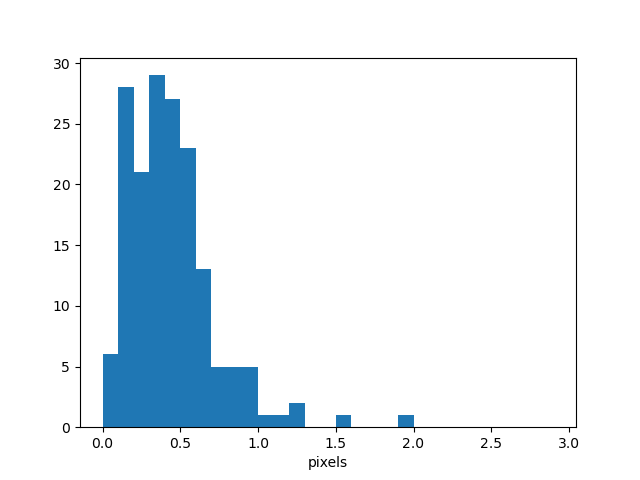

In [24]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);
ax.set_xlabel('pixels')

## XZ&YZ to XY

In [25]:
X_data = np.copy(xz_yz_image_coordinates)
Y_data = np.copy(xy_image_coordinates)

In [26]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.01, 'preprocessor__degree': 3}
-0.2668300099828393


t = 0.2116532325744629 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
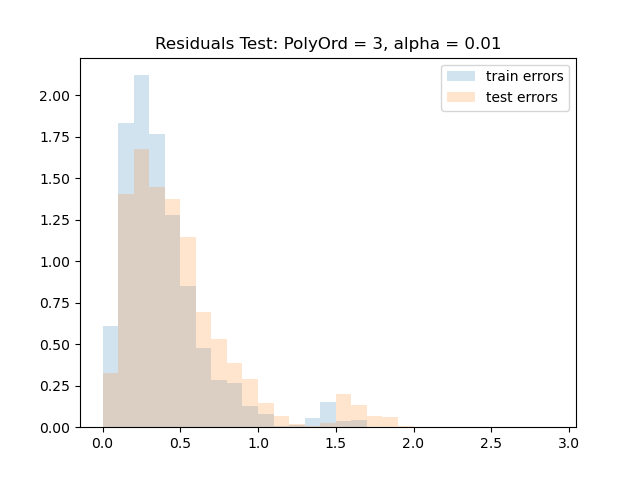

In [27]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [28]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xz_yz_to_xy.joblib'


In [29]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [30]:
# ---- compute the final residuals plot ---- #

# load the model
xy_getter_name = 'xz_yz_to_xy.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xy_getter = load(os.path.join(python_calibration_folderPath, xy_getter_name));


calculated_im_coordinates = xy_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
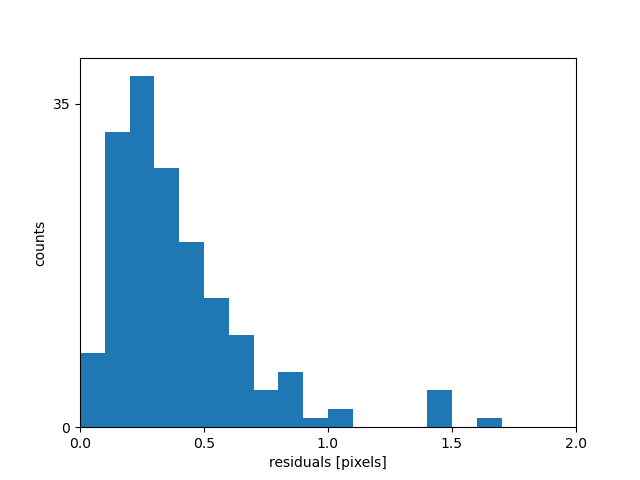

In [31]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 40)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])


## XZ&XY&YZ to XYZ

In [32]:
X_data = np.copy(flat_image_coordinates)
Y_data = np.copy(measured_coordinates)

In [33]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.1, 'preprocessor__degree': 2}
-0.014949662981693979


t = 0.2060103416442871 s



Text(0.5, 0, '[cm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
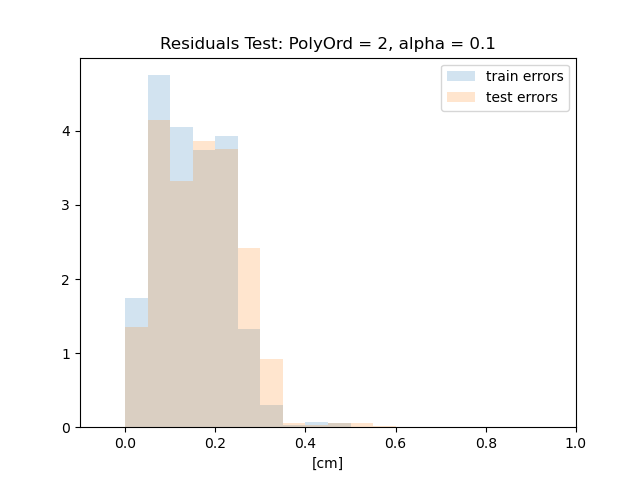

In [34]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.05)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.xticks([0.2*i for i in range(15)])
plt.legend()
plt.xlim(-0.1,1)
plt.xlabel('[cm]')

In [35]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'imCoords_to_XYZ.joblib'


In [36]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [37]:
# ---- compute the final residuals plot ---- #

# load the model
xyz_getter_name = 'imCoords_to_XYZ.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xyz_getter = load(os.path.join(python_calibration_folderPath, xyz_getter_name));


calculated_im_coordinates = xyz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
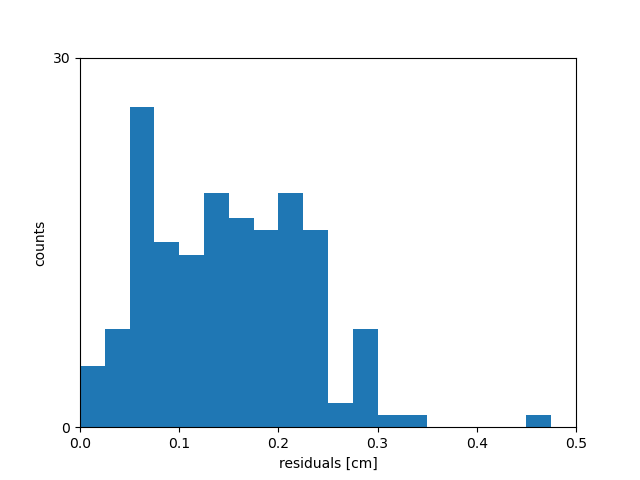

In [38]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 0.8, 0.025)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [cm]')

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 30)

ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5]);
ax.set_yticks([0, 30])


# 20200325_calibration

## load data

In [39]:
calibration_folder_path = './20200325_calibration/'


# set the folder containing the calibration information
measured_coord_folder = os.path.join(calibration_folder_path, 'measured_coords/')
image_coord_folder = os.path.join(calibration_folder_path, 'image_coords/')

# make a list of the text files we need to read from each position folder
imcoord_textfileNames = ['Ex_data_corner.txt', 'Ex_data.txt', 'Ez_data_corner_fixed.txt', 'Ez_data_fixed.txt', \
                         'Fx_data_corner.txt', 'Fx_data.txt', 'Fy_data_corner_fixed.txt', 'Fy_data_fixed.txt', \
                         'Gy_data_corner.txt', 'Gy_data.txt', 'Gz_data_corner_fixed.txt', 'Gz_data_fixed.txt']

measured_textfileNames = ['pos1_measured.txt', 'pos1corner_measured.txt',
                          'pos2_measured.txt', 'pos2corner_measured.txt',
                          'pos3_measured.txt', 'pos3corner_measured.txt',
                          'pos4_measured.txt', 'pos4corner_measured.txt']

#position_names = ['position1', 'position2', 'position3', 'position4']
position_names = ['rotation1', 'rotation2', 'rotation3', 'rotation4']

# load the measured coordinates
measured_coordinates = []
for i in range(0, len(measured_textfileNames), 2):
    # get paths
    non_corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i])
    corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i+1])
    # load the data
    non_corner_data = np.loadtxt(non_corner_path)
    corner_data = np.loadtxt(corner_path)
    # combine the two
    position_measured_coords = np.concatenate((non_corner_data, corner_data))
    # record
    measured_coordinates.append(position_measured_coords)
full_measured_coordinates = np.vstack(measured_coordinates)

# load the image coordinates
xz_imCoords = []
xy_imCoords = []
yz_imCoords = []

for positionIdx in range(4):
    folder_name = os.path.join(image_coord_folder, position_names[positionIdx])
    
    Ex_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[0]))
    Ex_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[1]))
    Ez_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[2]))
    Ez_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[3]))
    Ex_data = np.concatenate((Ex_non_corner_data, Ex_corner_data))
    Ez_data = np.concatenate((Ez_non_corner_data, Ez_corner_data))
    
    Fx_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[4]))
    Fx_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[5]))
    Fy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[6]))
    Fy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[7]))
    Fx_data = np.concatenate((Fx_non_corner_data, Fx_corner_data))
    Fy_data = np.concatenate((Fy_non_corner_data, Fy_corner_data))
    
    Gy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[8]))
    Gy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[9]))
    Gz_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[10]))
    Gz_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[11]))
    Gy_data = np.concatenate((Gy_non_corner_data, Gy_corner_data))
    Gz_data = np.concatenate((Gz_non_corner_data, Gz_corner_data))
    
    # Combine the two arrays for each cam
    # BIG DANGER OF A SWAP! e.g (Ex,Ez), or (Ez,Ex)
    # WE WANT OPENCV FORMAT I THINK?
    xz_data = np.stack([Ex_data, Ez_data], axis=1)
    xy_data = np.stack([Fx_data, Fy_data], axis=1)
    yz_data = np.stack([Gy_data, Gz_data], axis=1)
    
    # record for this position
    xz_imCoords.append(xz_data)
    xy_imCoords.append(xy_data)
    yz_imCoords.append(yz_data)
    
# combine the data for each position
xz_imCoords = np.concatenate(xz_imCoords)
xy_imCoords = np.concatenate(xy_imCoords)
yz_imCoords = np.concatenate(yz_imCoords)

# combine into master array
full_image_coordinates = np.stack([xz_imCoords, xy_imCoords, yz_imCoords], axis=0)

# load the raw images (if you like - not necessary for regressing functions)
raw_image_folder = os.path.join(calibration_folder_path, 'raw_images')

image_extensions = ['xz_rotation1.tif', 'xz_rotation2.tif', 'xz_rotation3.tif', 'xz_rotation4.tif',
                    'xy_rotation1.tif', 'xy_rotation2.tif', 'xy_rotation3.tif', 'xy_rotation4.tif',
                    'yz_rotation1.tif', 'yz_rotation2.tif', 'yz_rotation3.tif', 'yz_rotation4.tif',
                    ]

image_filepaths = [os.path.join(raw_image_folder, image_extension) for image_extension in image_extensions]

# load the images as a list
images = []
for imPath in image_filepaths:
    images.append(plt.imread(imPath))
    
# turn into an array of shape (numCams, numRotations, 1024, 1280)
calibration_images = np.stack(images)
calibration_images = calibration_images.reshape(3,4,1024,1280)
print()
print('calibration_images_shape: ', calibration_images.shape)
print()
print()

print('-- Full Measured Coordinates --')
print('(numBalls, 3D_coord)')
print(full_measured_coordinates.shape)
print()
print('-- Full Image coordinates --')
print('(numCams, numBalls, 2D_coord)')
print(full_image_coordinates.shape)

total_numBalls = full_measured_coordinates.shape[0]
print(total_numBalls)


calibration_images_shape:  (3, 4, 1024, 1280)


-- Full Measured Coordinates --
(numBalls, 3D_coord)
(200, 3)

-- Full Image coordinates --
(numCams, numBalls, 2D_coord)
(3, 200, 2)
200


## parse to within interior cage and inspect

Text(0.5, 0, 'Z [cm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
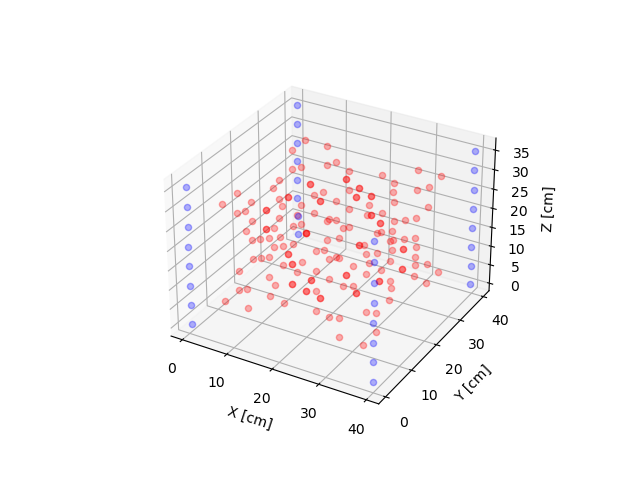

In [40]:
# parse the image coordinates - we only want to use calibration balls which lie within the interior volume

def is_within_interior_cage(XYZ):
    ''' Return True if this 3D values is within the iterior cage,
        False otherwise
    '''
    # define the X, Y and Z ranges of the iterior cage
    iterior_cage_lims = np.array([[5,35],[5,35],[0,32]])
    # preallocate a list to hold the success for the checking of each dimension
    dim_successes = [False]*3
    # check each dimension, does component lie within the cage component limits?
    for i,dim_range in enumerate(iterior_cage_lims):
        if dim_range[0] <= XYZ[i] <= dim_range[1]:
            dim_successes[i] = True
    # If all 3 are successes, then we return True
    if np.all(dim_successes):
        return True
    else:
        return False
    
    
# create the mask of balls within the interior cage
new_meas_list = []
new_im_list = []
within_mask = np.zeros((total_numBalls,), dtype=bool)
for ballIdx in range(total_numBalls):
    if is_within_interior_cage(full_measured_coordinates[ballIdx]):
        new_meas_list.append(full_measured_coordinates[ballIdx])
        new_im_list.append(full_image_coordinates[:,ballIdx])
        within_mask[ballIdx] = True
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# set the colors
# 2D arrays with a single row
within_color = np.array([1,0,0,0.3]).reshape(1,-11)
outside_color = np.array([0,0,1,0.3]).reshape(1,-11)

# plot the interior balls we use
ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c=within_color, depthshade=False)

# plot the balls outside the interior cage
ax.scatter(full_measured_coordinates[~within_mask,0], 
           full_measured_coordinates[~within_mask,1], 
           full_measured_coordinates[~within_mask,2], 
           marker='o', c=outside_color, depthshade=False)

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')

In [41]:
# Now define measured and image coordinates to only use interior points
measured_coordinates = full_measured_coordinates[within_mask]
image_coordinates = full_image_coordinates[:, within_mask]

print(measured_coordinates.shape)
print(image_coordinates.shape)

numBalls = measured_coordinates.shape[0]
print(numBalls)

(168, 3)
(3, 168, 2)
168


## prepare the data to use for building the models

In [43]:
# prepare the image coordinates 
xz_xy_image_coordinates = np.copy(image_coordinates[:2,:,:].swapaxes(0,1).reshape(numBalls, -1))
xy_yz_image_coordinates = np.copy(image_coordinates[1:,:,:].swapaxes(0,1).reshape(numBalls, -1))
xz_yz_image_coordinates = np.copy(image_coordinates[::2,:,:].swapaxes(0,1).reshape(numBalls, -1))

xz_image_coordinates = np.copy(image_coordinates[0,:,:])
xy_image_coordinates = np.copy(image_coordinates[1,:,:])
yz_image_coordinates = np.copy(image_coordinates[2,:,:])

# I need to transform from (numCams,numBalls,2) to (numBalls,6)
flat_image_coordinates = np.copy(image_coordinates.swapaxes(0,1).reshape(-1,6))

print(xz_xy_image_coordinates.shape)
print(xy_yz_image_coordinates.shape)
print(xz_yz_image_coordinates.shape)
print()
print(xz_image_coordinates.shape)
print(xy_image_coordinates.shape)
print(yz_image_coordinates.shape)
print()
print(measured_coordinates.shape)
print()
print(flat_image_coordinates.shape)

(168, 4)
(168, 4)
(168, 4)

(168, 2)
(168, 2)
(168, 2)

(168, 3)

(168, 6)


## XZ&XY to YZ

In [44]:
X_data = np.copy(xz_xy_image_coordinates)
Y_data = np.copy(yz_image_coordinates)

In [45]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.01, 'preprocessor__degree': 3}
-0.18526780980263088


t = 0.21239686012268066 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
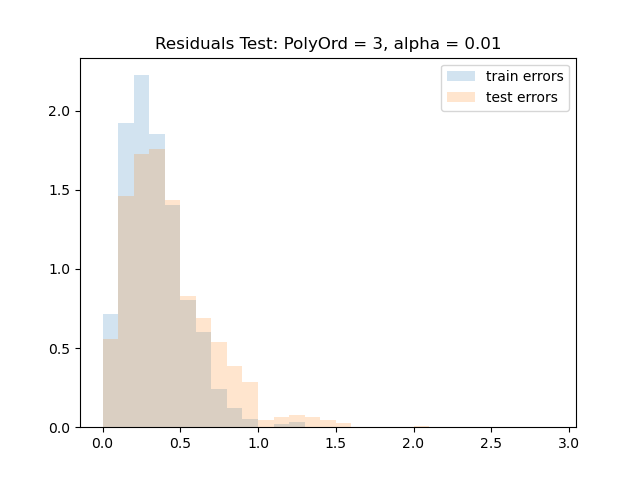

In [46]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [47]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xz_xy_to_yz.joblib'


In [48]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [49]:
# ---- How to load ----#

# # load the model
# yz_getter_name = 'xz_xy_to_yz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));

In [50]:
# ---- compute the final residuals plot ---- #

# load the model
yz_getter_name = 'xz_xy_to_yz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));


calculated_im_coordinates = yz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
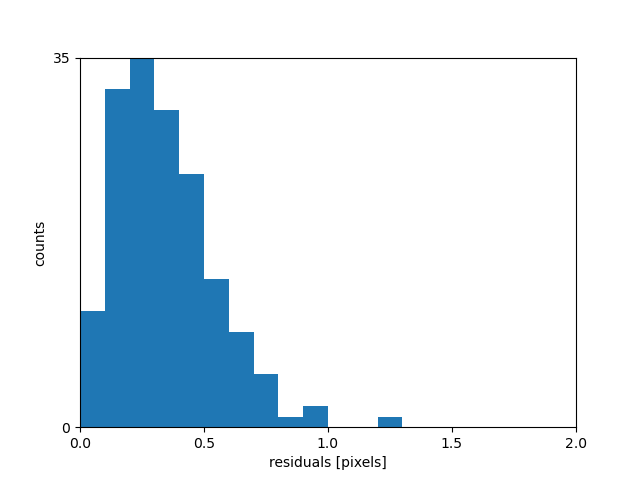

In [51]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])

## XY&YZ to XZ

In [52]:
X_data = np.copy(xy_yz_image_coordinates)
Y_data = np.copy(xz_image_coordinates)

In [53]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.01, 'preprocessor__degree': 3}
-0.22524803214094843


t = 0.19748616218566895 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
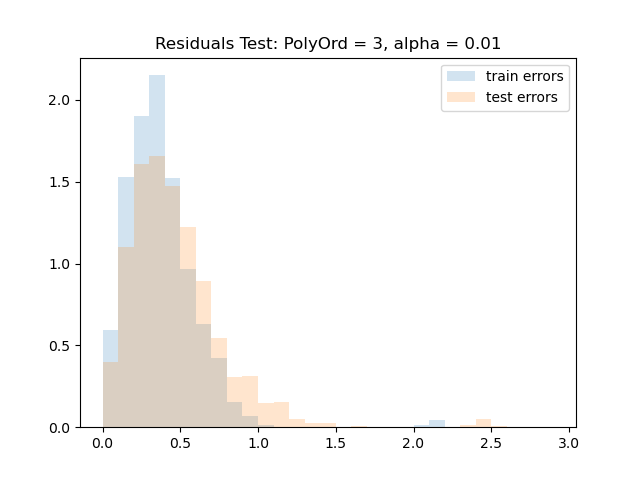

In [54]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [55]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xy_yz_to_xz.joblib'


In [56]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [57]:
# ---- How to load ----#

# # load the model
# xz_getter_name = 'xy_yz_to_xz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));

In [58]:
# ---- compute the final residuals plot ---- #

# load the model
xz_getter_name = 'xy_yz_to_xz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));


calculated_im_coordinates = xz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Text(0.5, 0, 'pixels')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
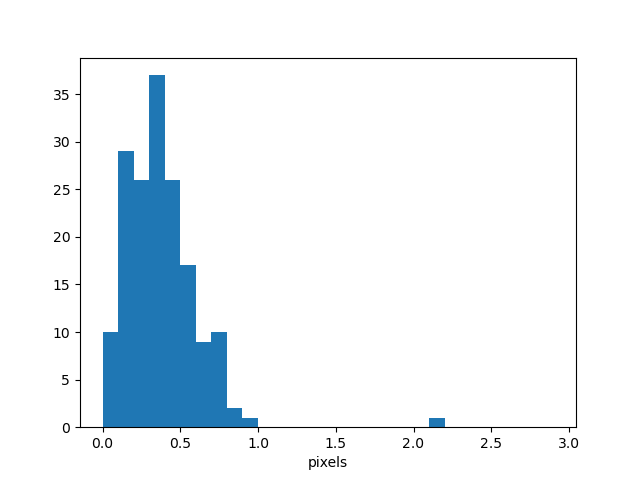

In [59]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);
ax.set_xlabel('pixels')

## XZ&YZ to XY

In [60]:
X_data = np.copy(xz_yz_image_coordinates)
Y_data = np.copy(xy_image_coordinates)

In [61]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.001, 'preprocessor__degree': 3}
-0.11939040012573625


t = 0.21138858795166016 s



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
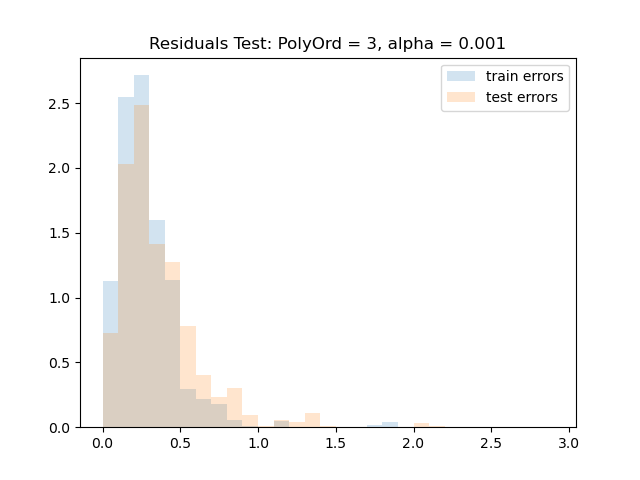

In [62]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.legend()

In [63]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'xz_yz_to_xy.joblib'


In [64]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [65]:
# ---- compute the final residuals plot ---- #

# load the model
xy_getter_name = 'xz_yz_to_xy.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xy_getter = load(os.path.join(python_calibration_folderPath, xy_getter_name));


calculated_im_coordinates = xy_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
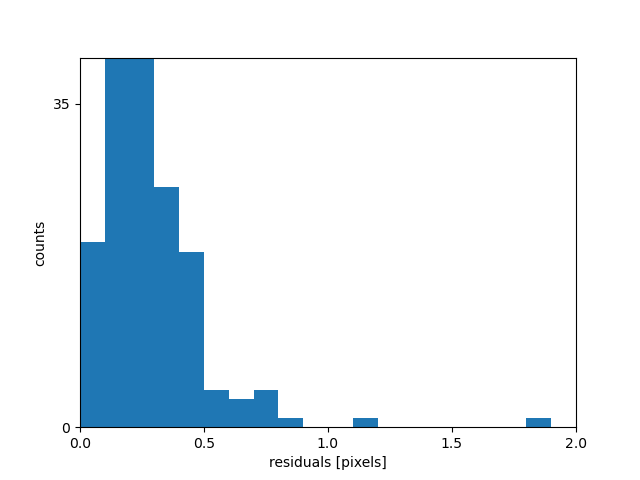

In [66]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 40)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])


## XZ&XY&YZ to XYZ

In [67]:
X_data = np.copy(flat_image_coordinates)
Y_data = np.copy(measured_coordinates)

In [68]:
# ---- STEP1: determine alpha parameter and polydegree ---- #

# set the parameters for the grid search
alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
polyDegList = [1, 2, 3, 4]
parameters = {'estimator__alpha': alpha,
              'preprocessor__degree': polyDegList}

# set the pipeline for building the model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(include_bias=True)),
    ('estimator', Ridge())
])

# set the gridsearch score metric
score = 'neg_mean_squared_error'

# perform a gridsearch
getter_GS = GridSearchCV(pipe, parameters, cv=3, scoring=score) 
getter_GS.fit(X_data, Y_data)


print(getter_GS.best_params_)
print(getter_GS.best_score_)

{'estimator__alpha': 0.1, 'preprocessor__degree': 2}
-0.010561701665143676


t = 0.2097949981689453 s



Text(0.5, 0, '[cm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
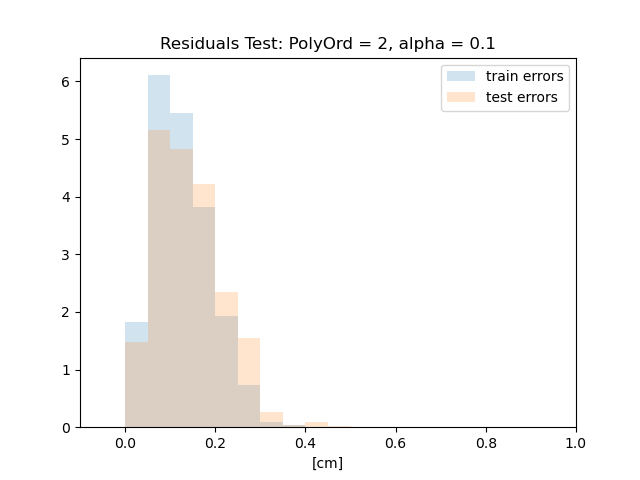

In [69]:
# ---- STEP2: examine the residuals and the amount of over-fitting ---- #
# 
# using the above-determined alpha and polydeg, examine the residuals for 
# a train-test split

# the number of training test splits
numPermutations = 100
# the proportion of the dataset to include in the train split
trainFac = 0.9
# the binning for plotting the residuals
bins = np.arange(0, 3, 0.05)

# --------------------------#

t0 = time.time()

# use the GS results to set the params
alpha = getter_GS.best_params_['estimator__alpha']
polyDeg = getter_GS.best_params_['preprocessor__degree']

# based on the trainFac, determine the number of balls to use for training
# we do this just for preallocating the results array below
dummy_X_train, _, _, _, = train_test_split(X_data, Y_data, train_size=trainFac)
numTrainingBalls = dummy_X_train.shape[0]

# preallocate arrays to hold the results
train_errors = np.zeros((numPermutations, numTrainingBalls))
test_errors = np.zeros((numPermutations, numBalls-numTrainingBalls))



for permIdx in range(numPermutations):

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=trainFac)

    getter = Pipeline(steps=[('scaler', StandardScaler()),
                                ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                                ('estimator', Ridge(alpha=alpha))
                                ])

    getter.fit(X_train, y_train)

    train_calculated_coordinates = getter.predict(X_train)
    errs = np.linalg.norm(y_train - train_calculated_coordinates, axis=1)
    train_errors[permIdx, :] = errs

    test_calculated_coordinates = getter.predict(X_test)
    errs = np.linalg.norm(y_test - test_calculated_coordinates, axis=1)
    test_errors[permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# flatten the error arrays for histogramming the distributions
train_errors = train_errors.reshape(-1)
test_errors = test_errors.reshape(-1)

plt.figure()
plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyDeg, alpha))
plt.hist(train_errors, label='train errors', bins=bins, alpha=0.2, density=True);
plt.hist(test_errors, label='test errors', bins=bins, alpha=0.2, density=True);
plt.xticks([0.2*i for i in range(15)])
plt.legend()
plt.xlim(-0.1,1)
plt.xlabel('[cm]')

In [70]:
# --------------- STEP3: Fit and save the final model ----------------#
getter_name = 'imCoords_to_XYZ.joblib'


In [71]:
# make the final model
getter = Pipeline(steps=[('scaler', StandardScaler()),
                         ('preprocessor', PolynomialFeatures(degree=polyDeg, include_bias=True)),
                          ('estimator', Ridge(alpha=alpha))
                          ])

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);

getter.fit(X_data, Y_data)

dump(getter, os.path.join(python_calibration_folderPath, getter_name));

In [72]:
# ---- compute the final residuals plot ---- #

# load the model
xyz_getter_name = 'imCoords_to_XYZ.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xyz_getter = load(os.path.join(python_calibration_folderPath, xyz_getter_name));


calculated_im_coordinates = xyz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
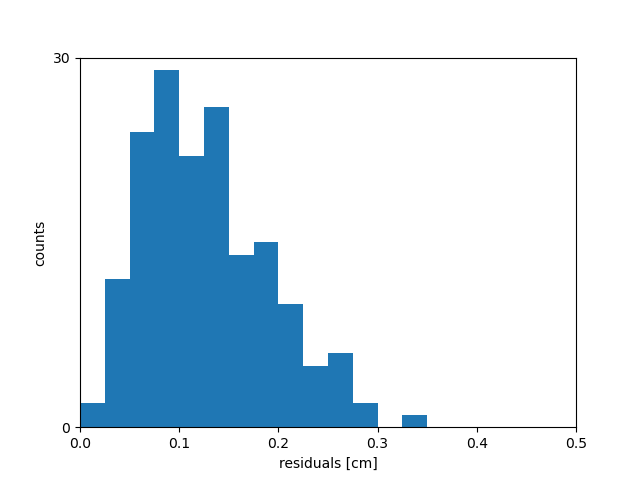

In [73]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 0.8, 0.025)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [cm]')

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 30)

ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5]);
ax.set_yticks([0, 30])
